# Compare predictions on kaggle data

In [1]:
library(tidyverse)
library(patchwork)
library(ggfortify)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
theme_set(theme_minimal())
options(repr.plot.width = 16)

In [3]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggfortify_0.4.9 patchwork_1.0.1 forcats_0.5.0   stringr_1.4.0  
 [5] dplyr_1.0.4     purrr_0.3.4     readr_1.4.0     tidyr_1.1.2    
 [9] tibble_3.0.6    ggplot2_3.3.3   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3      tidyselect_1.1.0  repr_1.1.0        haven_2.3.1      
 [5] colorspa

## Compare ukbb_cardiac to kaggle lables

In [4]:
ukbb_pred <- read_csv("../../analysis/kaggle/ukbb_ventricular_volumes.csv") %>% rename(Id = X1) %>% mutate(pid=str_replace_all(Id,"_rot90",""))
metadata <- read_tsv("../../analysis/kaggle/patient_metadata.tsv")

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  `LVEDV (mL)` = col_double(),
  `LVESV (mL)` = col_double(),
  `LVSV (mL)` = col_double(),
  `LVEF (%)` = col_double(),
  `LVCO (L/min)` = col_double(),
  `LVM (g)` = col_double(),
  `RVEDV (mL)` = col_double(),
  `RVESV (mL)` = col_double(),
  `RVSV (mL)` = col_double(),
  `RVEF (%)` = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PatientsAgeNum = col_character(),
  PatientsAgeUnit = col_character(),
  PatientsSex = col_character(),
  pid = col_character(),
  used = col_logical(),
  set = col_character(),
  PhaseEncodingDirection = col_character(),
  ModelName = col_character(),
  PixelSpacing = col_character(),
  ScanningSequence = col_character(),
  SequenceName = col_character(),
  SequenceVariant = col_character(),
  Softwar

In [5]:
data <- ukbb_pred %>% select(Id,pid,LVEDV=`LVEDV (mL)`,LVESV=`LVESV (mL)`,LVEF=`LVEF (%)`) %>%
    left_join(metadata, by="pid")

In [6]:
data <- data %>% mutate(AgeBin = cut(PatientsAgeYears, breaks=c(0,20,40,70,100)))

### Prediction performance depending on age and field strength

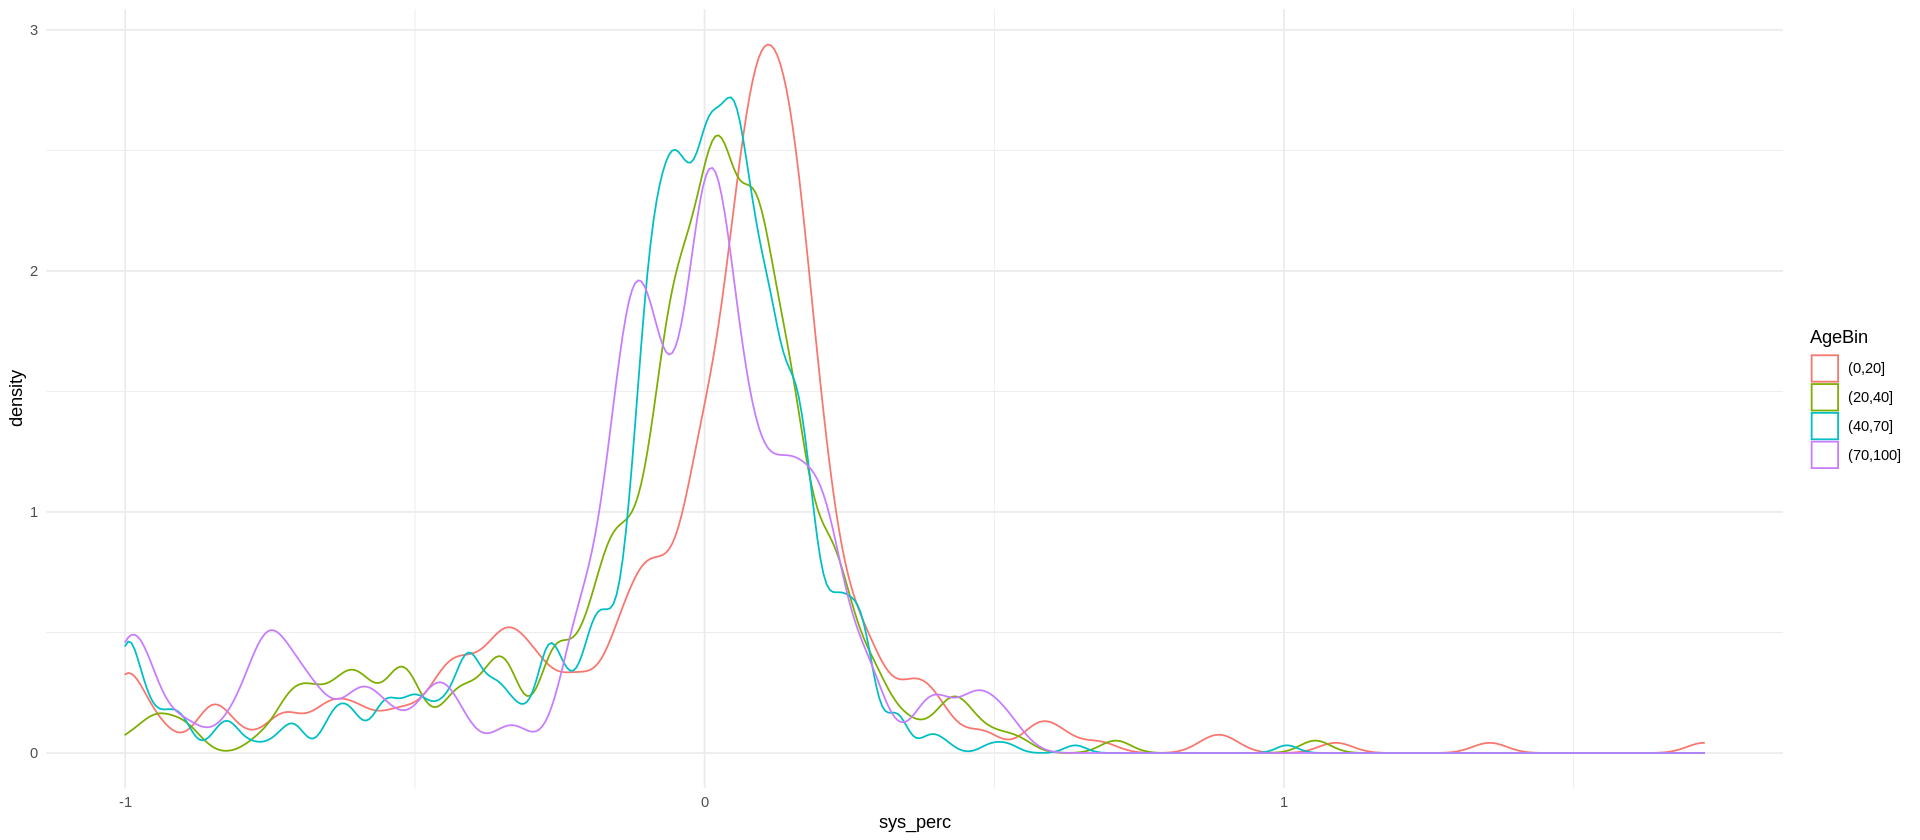

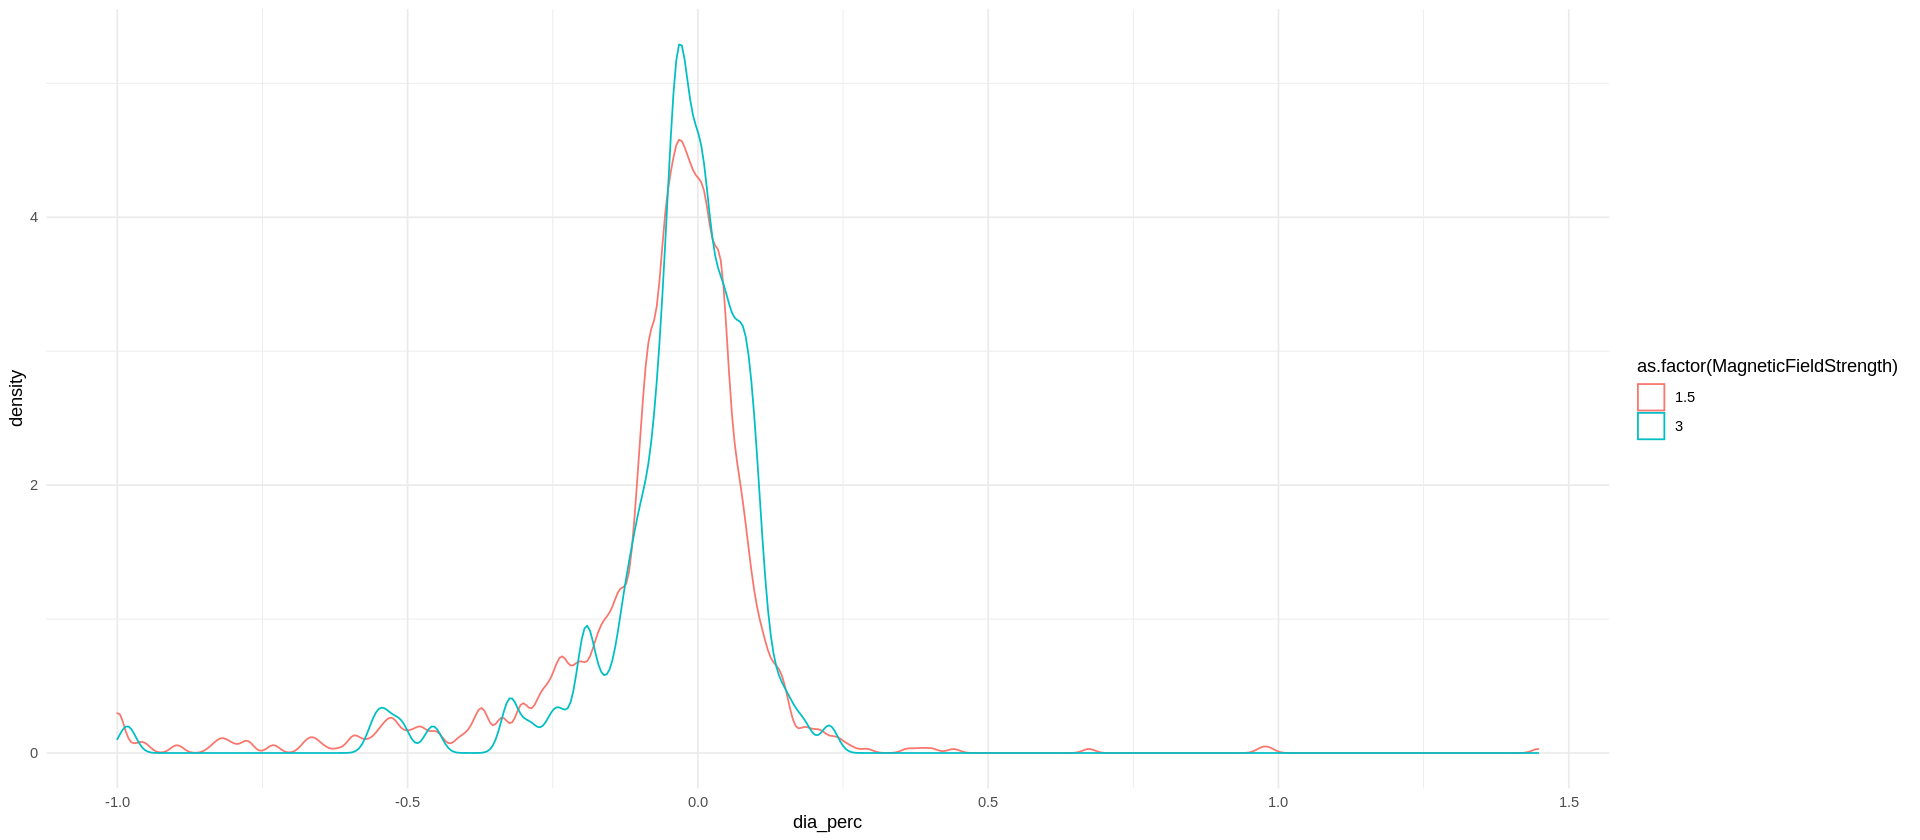

In [7]:
diff_data <- data %>%
    mutate(sys_diff = LVESV-Systole, sys_perc = sys_diff/Systole) %>%
    mutate(dia_diff = LVEDV-Diastole, dia_perc = dia_diff/Diastole) %>%
    mutate(max_abs_perc_diff = pmax(abs(sys_perc),abs(dia_perc)))
diff_data %>% filter(sys_perc<2) %>%
    ggplot(aes(x=sys_perc,color=AgeBin)) +
    geom_density(adjust=.5)
diff_data %>% filter(dia_perc<2) %>%
    ggplot(aes(x=dia_perc,color=as.factor(MagneticFieldStrength))) +
    geom_density(adjust=.5)

### Size of confidence sets

In [8]:
image_list_filtered_scored <- read_tsv("../../analysis/kaggle/image_list_filtered_score.tsv", guess_max = 10000)


── Column specification ────────────────────────────────────────────────────────
cols(
  Id = col_character(),
  file = col_character(),
  pid = col_character(),
  score = col_double(),
  set = col_character(),
  is_val = col_logical()
)




In [9]:
image_list_filtered_scored %>%
    mutate(confSet = case_when(
        score <= .05 ~ "p05",
        score <= .10 ~ "p10",
        score <= .15 ~ "p15",
        TRUE ~ "rest"
    )) %>% select(confSet, pid) %>% unique %>% count(confSet) %>% mutate(cs = cumsum(n))

confSet n   cs  
1 p05     175  175
2 p10     345  520
3 p15     243  763
4 rest    386 1149

In [10]:
image_list_filtered_scored %>%
    mutate(confSet = case_when(
        score <= .05 ~ "p05",
        score <= .10 ~ "p10",
        score <= .15 ~ "p15",
        TRUE ~ "rest"
    )) %>% count(confSet) %>% mutate(cs = cumsum(n))

confSet n      cs    
1 p05      54540  54540
2 p10     107940 162480
3 p15      75870 238350
4 rest    119410 357760

### Compare rot90 to unrotated

In [11]:
rot_data <- diff_data %>% mutate(rot90 = str_detect(Id, "rot90")) %>% select(pid, rot90, score=max_abs_perc_diff) %>% spread(rot90,score) %>%
    transmute(
        pid,
        rot90=`TRUE`,
        original=if_else(is.na(rot90),as.numeric(NA),`FALSE`),
        unchanged=if_else(is.na(rot90),`FALSE`,as.numeric(NA))
    )

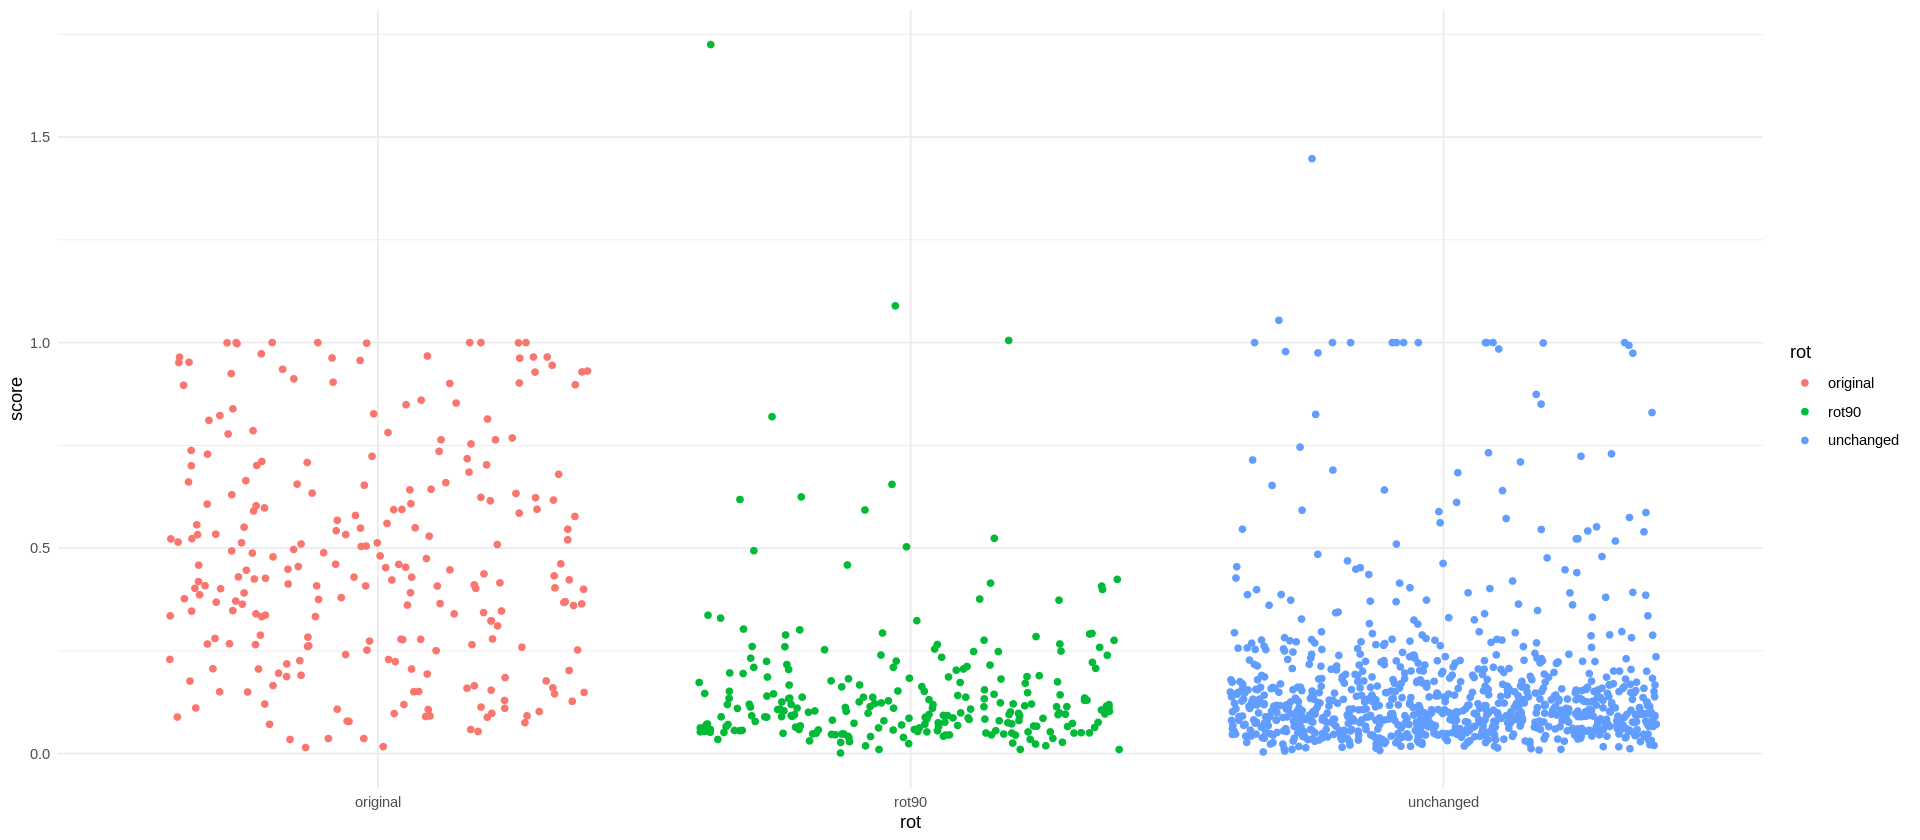

In [12]:
rot_data %>% gather("rot", "score", 2:4) %>% filter(!is.na(score)) %>% ggplot(aes(rot,score,color=rot)) + geom_jitter()

Split data set into rotated and unrotated

In [13]:
data_no_un_rot <- data %>% filter(str_detect(Id, "rot90") | Y>=X)

In [14]:
data_un_rot <- data %>% filter(!str_detect(Id, "rot90") & X>Y)

## Our predictions with fastai models

In [15]:
get_own_predictions <- function(file, size=256){
    own_pred <- read_tsv(file)
    # get Id, frame and slice from filename
    own_pred <- own_pred %>%
        mutate(file=str_replace(file,"nifti/images/.*/","")) %>%
        separate(file,into=c("Id","frame","slice"),sep="-") %>%
        mutate(
            frame=str_replace(frame,"frame",""),
            frame=as.numeric(frame),
            slice=str_replace(slice,"slice",""),
            slice=str_replace(slice,".png",""),
            slice=as.numeric(slice)
        )
    # sum voxels in all slices per frame
    own_pred <- own_pred %>% group_by(Id, frame) %>% summarise(lv_voxels=sum(lv_pixels))
    # get systolic (least) and diastolic (most) frames
    own_pred_dia <- own_pred %>%
        group_by(Id) %>%
        top_n(1, lv_voxels) %>%
        top_n(1, frame) # in case of ties keep only highest frame
    own_pred_sys <- own_pred %>%
        group_by(Id) %>%
        top_n(1, -lv_voxels) %>%
        top_n(1, -frame) # in case of ties keep only lowest frame
    own_pred_both <- left_join(
        select(own_pred_dia,Id,dia_voxels=lv_voxels),
        select(own_pred_sys,Id,sys_voxels=lv_voxels)
    ) %>% mutate(pid=str_replace(Id,"_rot90",""))
    patient_dimensions <- select(metadata, pid, X, Y, pixelSpacingX, pixelSpacingY, sliceSpacing) %>%
        mutate(maxdim=pmax(X,Y),quadraticSliceVolume=(maxdim*maxdim*pixelSpacingX*pixelSpacingY*sliceSpacing)) %>%
        transmute(pid,voxelVolume=quadraticSliceVolume/(1000*size*size))
    own_pred_full <- left_join(own_pred_both, patient_dimensions, by="pid") %>%
        mutate(own_dia=dia_voxels*voxelVolume, own_sys=sys_voxels*voxelVolume) %>%
        select(Id, own_dia, own_sys)
    return(own_pred_full)
}

In [16]:
rn34_5percent_256 <- get_own_predictions("../../analysis/kaggle/predictions/resnet34_5percent_size256_normalTfms_ceLoss.tsv.xz", 256)
rn50_5percent_256 <- get_own_predictions("../../analysis/kaggle/predictions/resnet50_5percent_size256_normalTfms_ceLoss.tsv.xz", 256)
vgg16_5percent_256 <- get_own_predictions("../../analysis/kaggle/predictions/vgg16_5percent_size256_normalTfms_ceLoss.tsv.xz", 256)
rn34_5percent_256_focal <- get_own_predictions("../../analysis/kaggle/predictions/resnet34_5percent_size256_normalTfms_focalLoss.tsv.xz", 256)
rn34_5percent_256_dice <- get_own_predictions("../../analysis/kaggle/predictions/resnet34_5percent_size256_normalTfms_softdiceLoss.tsv.xz", 256)
rn34_10percent_256 <- get_own_predictions("../../analysis/kaggle/predictions/resnet34_10percent_size256_normalTfms_ceLoss.tsv.xz", 256)
rn34_15percent_256 <- get_own_predictions("../../analysis/kaggle/predictions/resnet34_15percent_size256_normalTfms_ceLoss.tsv.xz", 256)
rn34_5percent_256_extremeTfms <- get_own_predictions("../../analysis/kaggle/predictions/resnet34_5percent_size256_extremeTfms_ceLoss.tsv.xz", 256)
rn34_5percent_128 <- get_own_predictions("../../analysis/kaggle/predictions/resnet34_5percent_size128_normalTfms_ceLoss.tsv.xz", 128)


── Column specification ────────────────────────────────────────────────────────
cols(
  file = col_character(),
  lv_pixels = col_double(),
  my_pixels = col_double()
)


`summarise()` has grouped output by 'Id'. You can override using the `.groups` argument.

Joining, by = "Id"


── Column specification ────────────────────────────────────────────────────────
cols(
  file = col_character(),
  lv_pixels = col_double(),
  my_pixels = col_double()
)


`summarise()` has grouped output by 'Id'. You can override using the `.groups` argument.

Joining, by = "Id"


── Column specification ────────────────────────────────────────────────────────
cols(
  file = col_character(),
  lv_pixels = col_double(),
  my_pixels = col_double()
)


`summarise()` has grouped output by 'Id'. You can override using the `.groups` argument.

Joining, by = "Id"


── Column specification ────────────────────────────────────────────────────────
cols(
  file = col_character(),
  lv_pixels = col_double(),
  my_pixe

In [17]:
systole <- data_no_un_rot %>%
    select(Id, GroundTruth=Systole, UKBB=LVESV) %>%
    left_join(select(rn34_5percent_128, Id, r34_p05_s128=own_sys), by="Id") %>%
    left_join(select(rn50_5percent_256, Id, r50_p05_s256=own_sys), by="Id") %>%
    left_join(select(vgg16_5percent_256, Id, v16_p05_s256=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256, Id, r34_p05_s256=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256_focal, Id, r34_p05_s256_focal=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256_dice, Id, r34_p05_s256_dice=own_sys), by="Id") %>%
    left_join(select(rn34_10percent_256, Id, r34_p10_s256=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256_extremeTfms, Id, r34_p05_s256_extremeTfms=own_sys), by="Id") %>%
    left_join(select(rn34_15percent_256, Id, r34_p15_s256=own_sys), by="Id") %>%
    gather("method", "prediction", -1:-2) %>%
    mutate(distance=prediction-GroundTruth)

diastole <- data_no_un_rot %>%
    select(Id, GroundTruth=Diastole, UKBB=LVEDV) %>%
    left_join(select(rn34_5percent_128, Id, r34_p05_s128=own_dia), by="Id") %>%
    left_join(select(rn50_5percent_256, Id, r50_p05_s256=own_dia), by="Id") %>%
    left_join(select(vgg16_5percent_256, Id, v16_p05_s256=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256, Id, r34_p05_s256=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256_focal, Id, r34_p05_s256_focal=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256_dice, Id, r34_p05_s256_dice=own_dia), by="Id") %>%
    left_join(select(rn34_10percent_256, Id, r34_p10_s256=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256_extremeTfms, Id, r34_p05_s256_extremeTfms=own_dia), by="Id") %>%
    left_join(select(rn34_15percent_256, Id, r34_p15_s256=own_dia), by="Id") %>%
    gather("method", "prediction", -1:-2) %>%
    mutate(distance=prediction-GroundTruth)

In [19]:
systole %>% write_tsv("../../analysis/kaggle/predictions/prediction_vs_gt_systole.tsv")
diastole %>% write_tsv("../../analysis/kaggle/predictions/prediction_vs_gt_diastole.tsv")

### EF

In [18]:
ef <- systole %>%
    left_join(diastole, by=c("Id","method")) %>%
    mutate(
        true_ef=(GroundTruth.y-GroundTruth.x)/GroundTruth.y,
        pred_ef=(prediction.y-prediction.x)/prediction.y, 
        distance=true_ef-pred_ef
    ) %>%
    replace_na(list(distance=1))

In [19]:
round_to = 4
ef %>% group_by(method) %>%
    mutate(distance=abs(distance)) %>%
    summarize(mean=mean(distance),sd=sd(distance),median=median(distance),iqr=IQR(distance),mad=mad(distance)) %>%
    arrange(mean) %>%
    mutate_if(is.numeric, round, 4) %>%
    mutate_if(is.numeric, `*`, 100)

method                   mean sd   median iqr  mad 
1  r34_p05_s256             3.64 3.38 2.87   3.72 2.66
2  r50_p05_s256             3.71 3.73 2.79   3.70 2.50
3  r34_p15_s256             3.73 3.38 2.91   3.72 2.55
4  r34_p05_s256_focal       3.75 3.90 2.86   3.80 2.61
5  r34_p10_s256             3.77 4.44 2.89   3.76 2.66
6  r34_p05_s256_extremeTfms 3.78 3.59 2.89   3.64 2.55
7  r34_p05_s128             3.90 4.26 3.05   3.86 2.70
8  r34_p05_s256_dice        3.93 3.43 3.07   3.91 2.73
9  v16_p05_s256             4.06 4.94 3.02   3.87 2.66
10 UKBB                     5.42 8.83 3.72   4.34 3.13

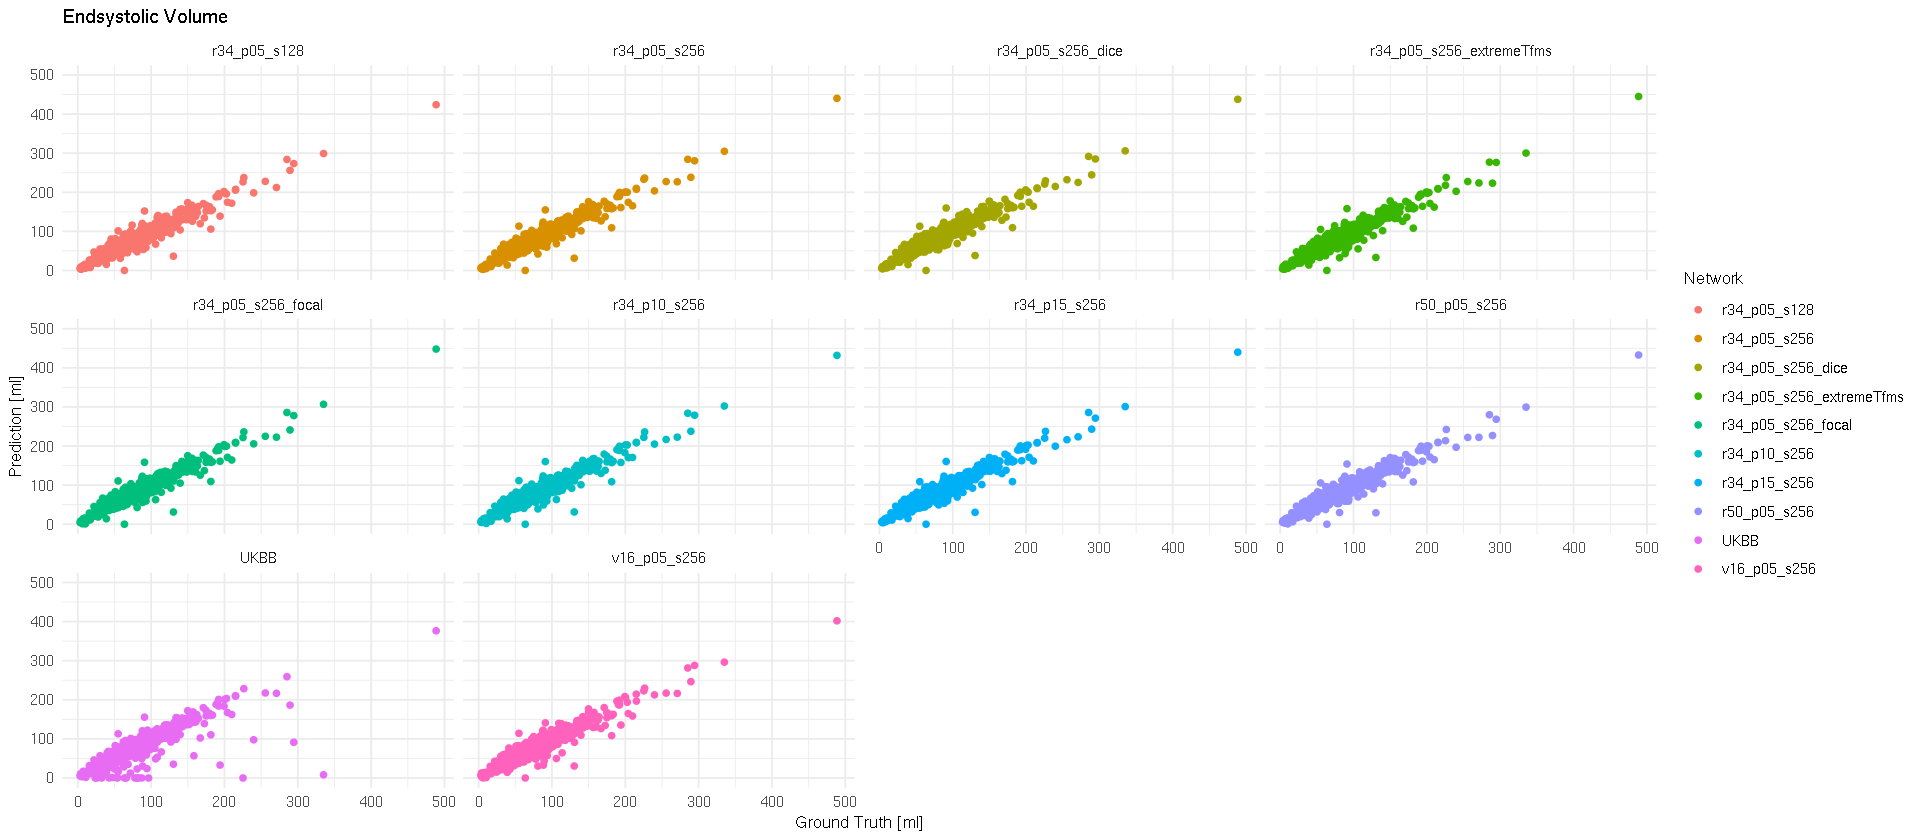

In [20]:
systole %>%
    mutate(Network = method) %>%
    ggplot(aes(GroundTruth, prediction, color=Network)) +
    geom_point() +
    ylim(c(0,500)) +
    facet_wrap(.~method) +
    ggtitle("Endsystolic Volume") +
    xlab("Ground Truth [ml]") +
    ylab("Prediction [ml]") +
    theme_minimal()

Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 44 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 44 rows containing missing values (geom_point).”

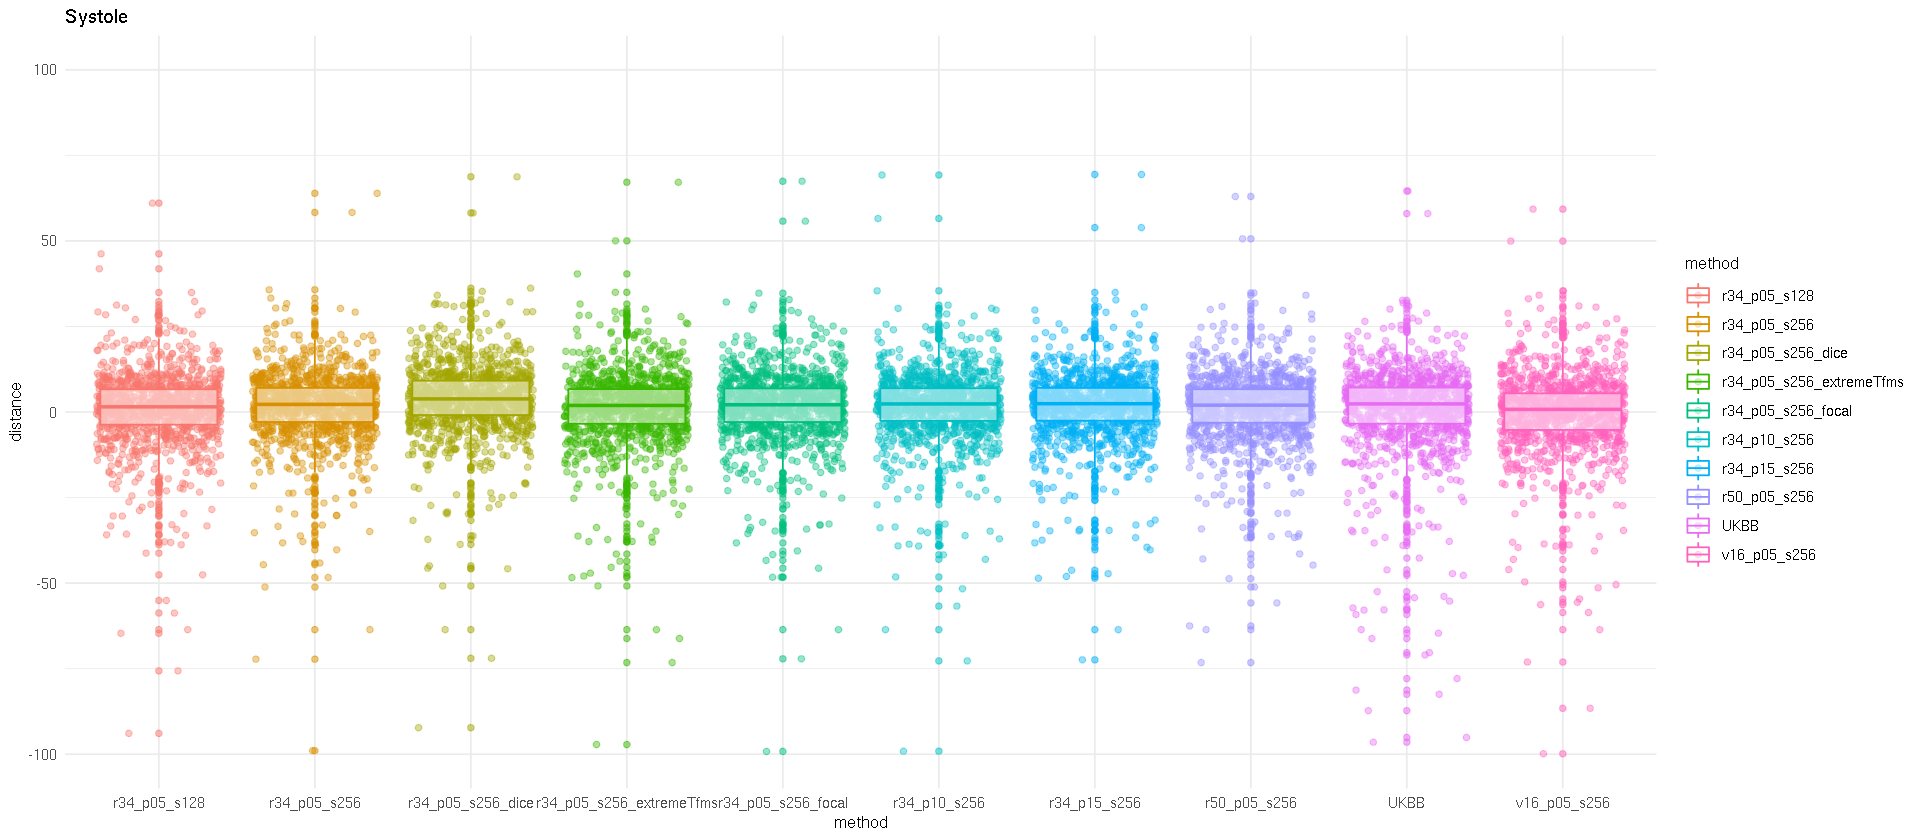

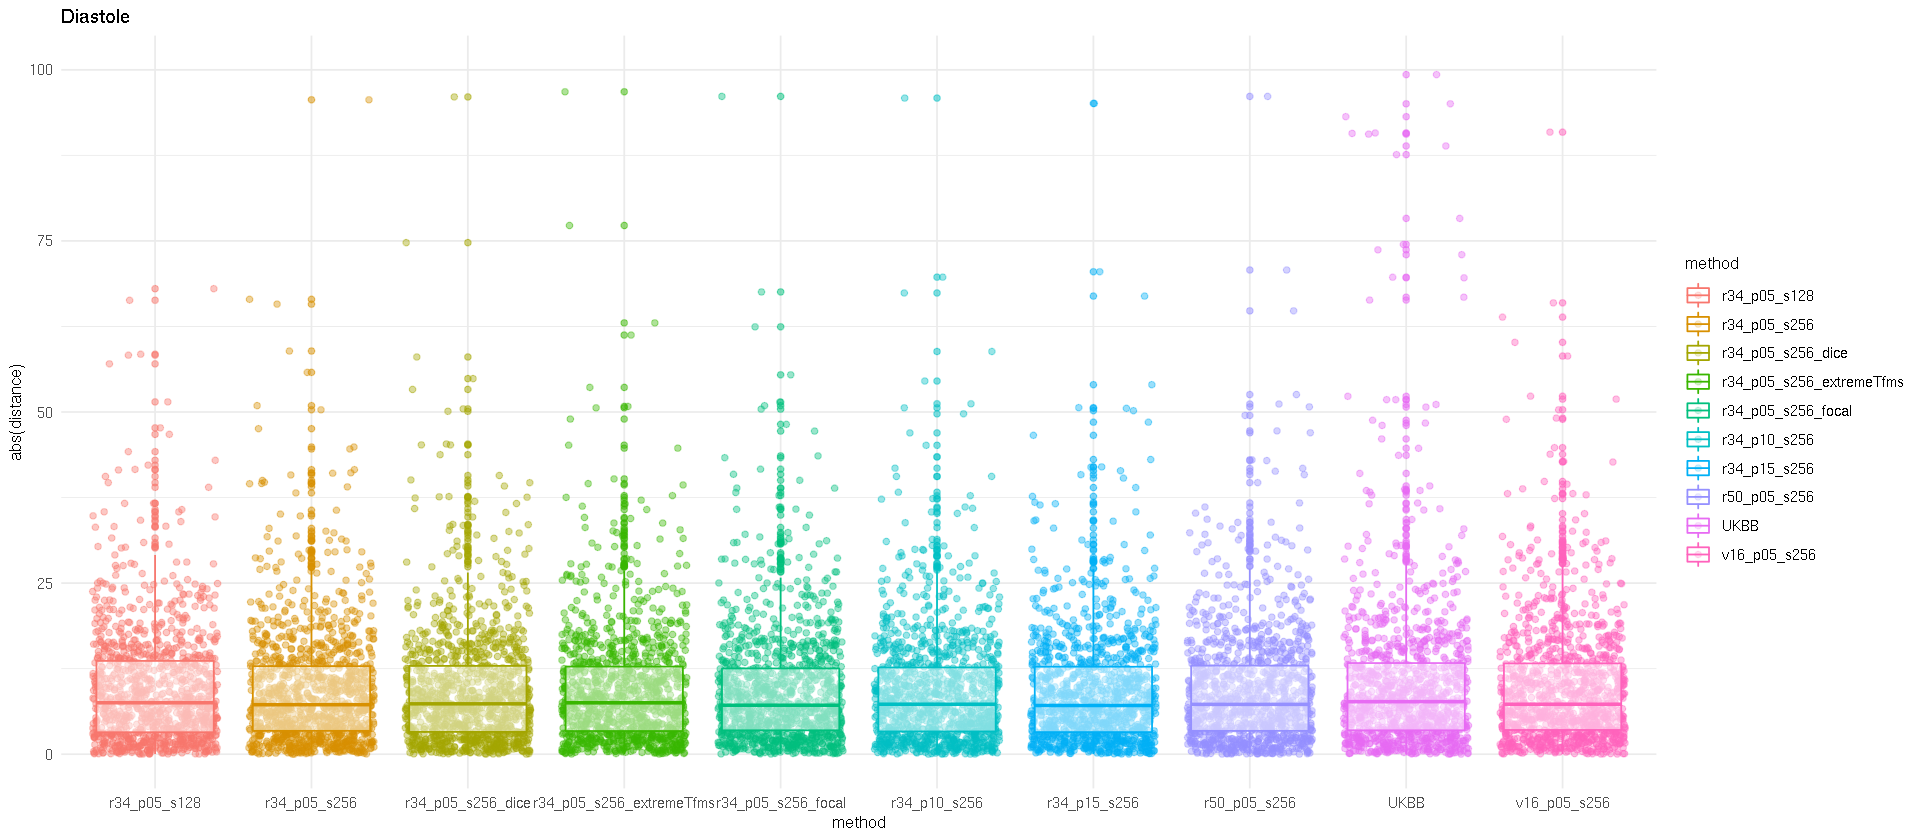

In [21]:
systole %>%
    ggplot(aes(method, distance, color=method)) +
    geom_jitter(alpha=.4) +
    geom_boxplot(alpha=.5) +
    ylim(c(-100,100)) +
    ggtitle("Systole") + theme_minimal()

diastole %>%
    ggplot(aes(method, abs(distance), color=method)) +
    geom_jitter(alpha=.4) +
    geom_boxplot(alpha=.5) +
    ylim(c(0,100)) +
    ggtitle("Diastole") + theme_minimal()

### Figure for publication

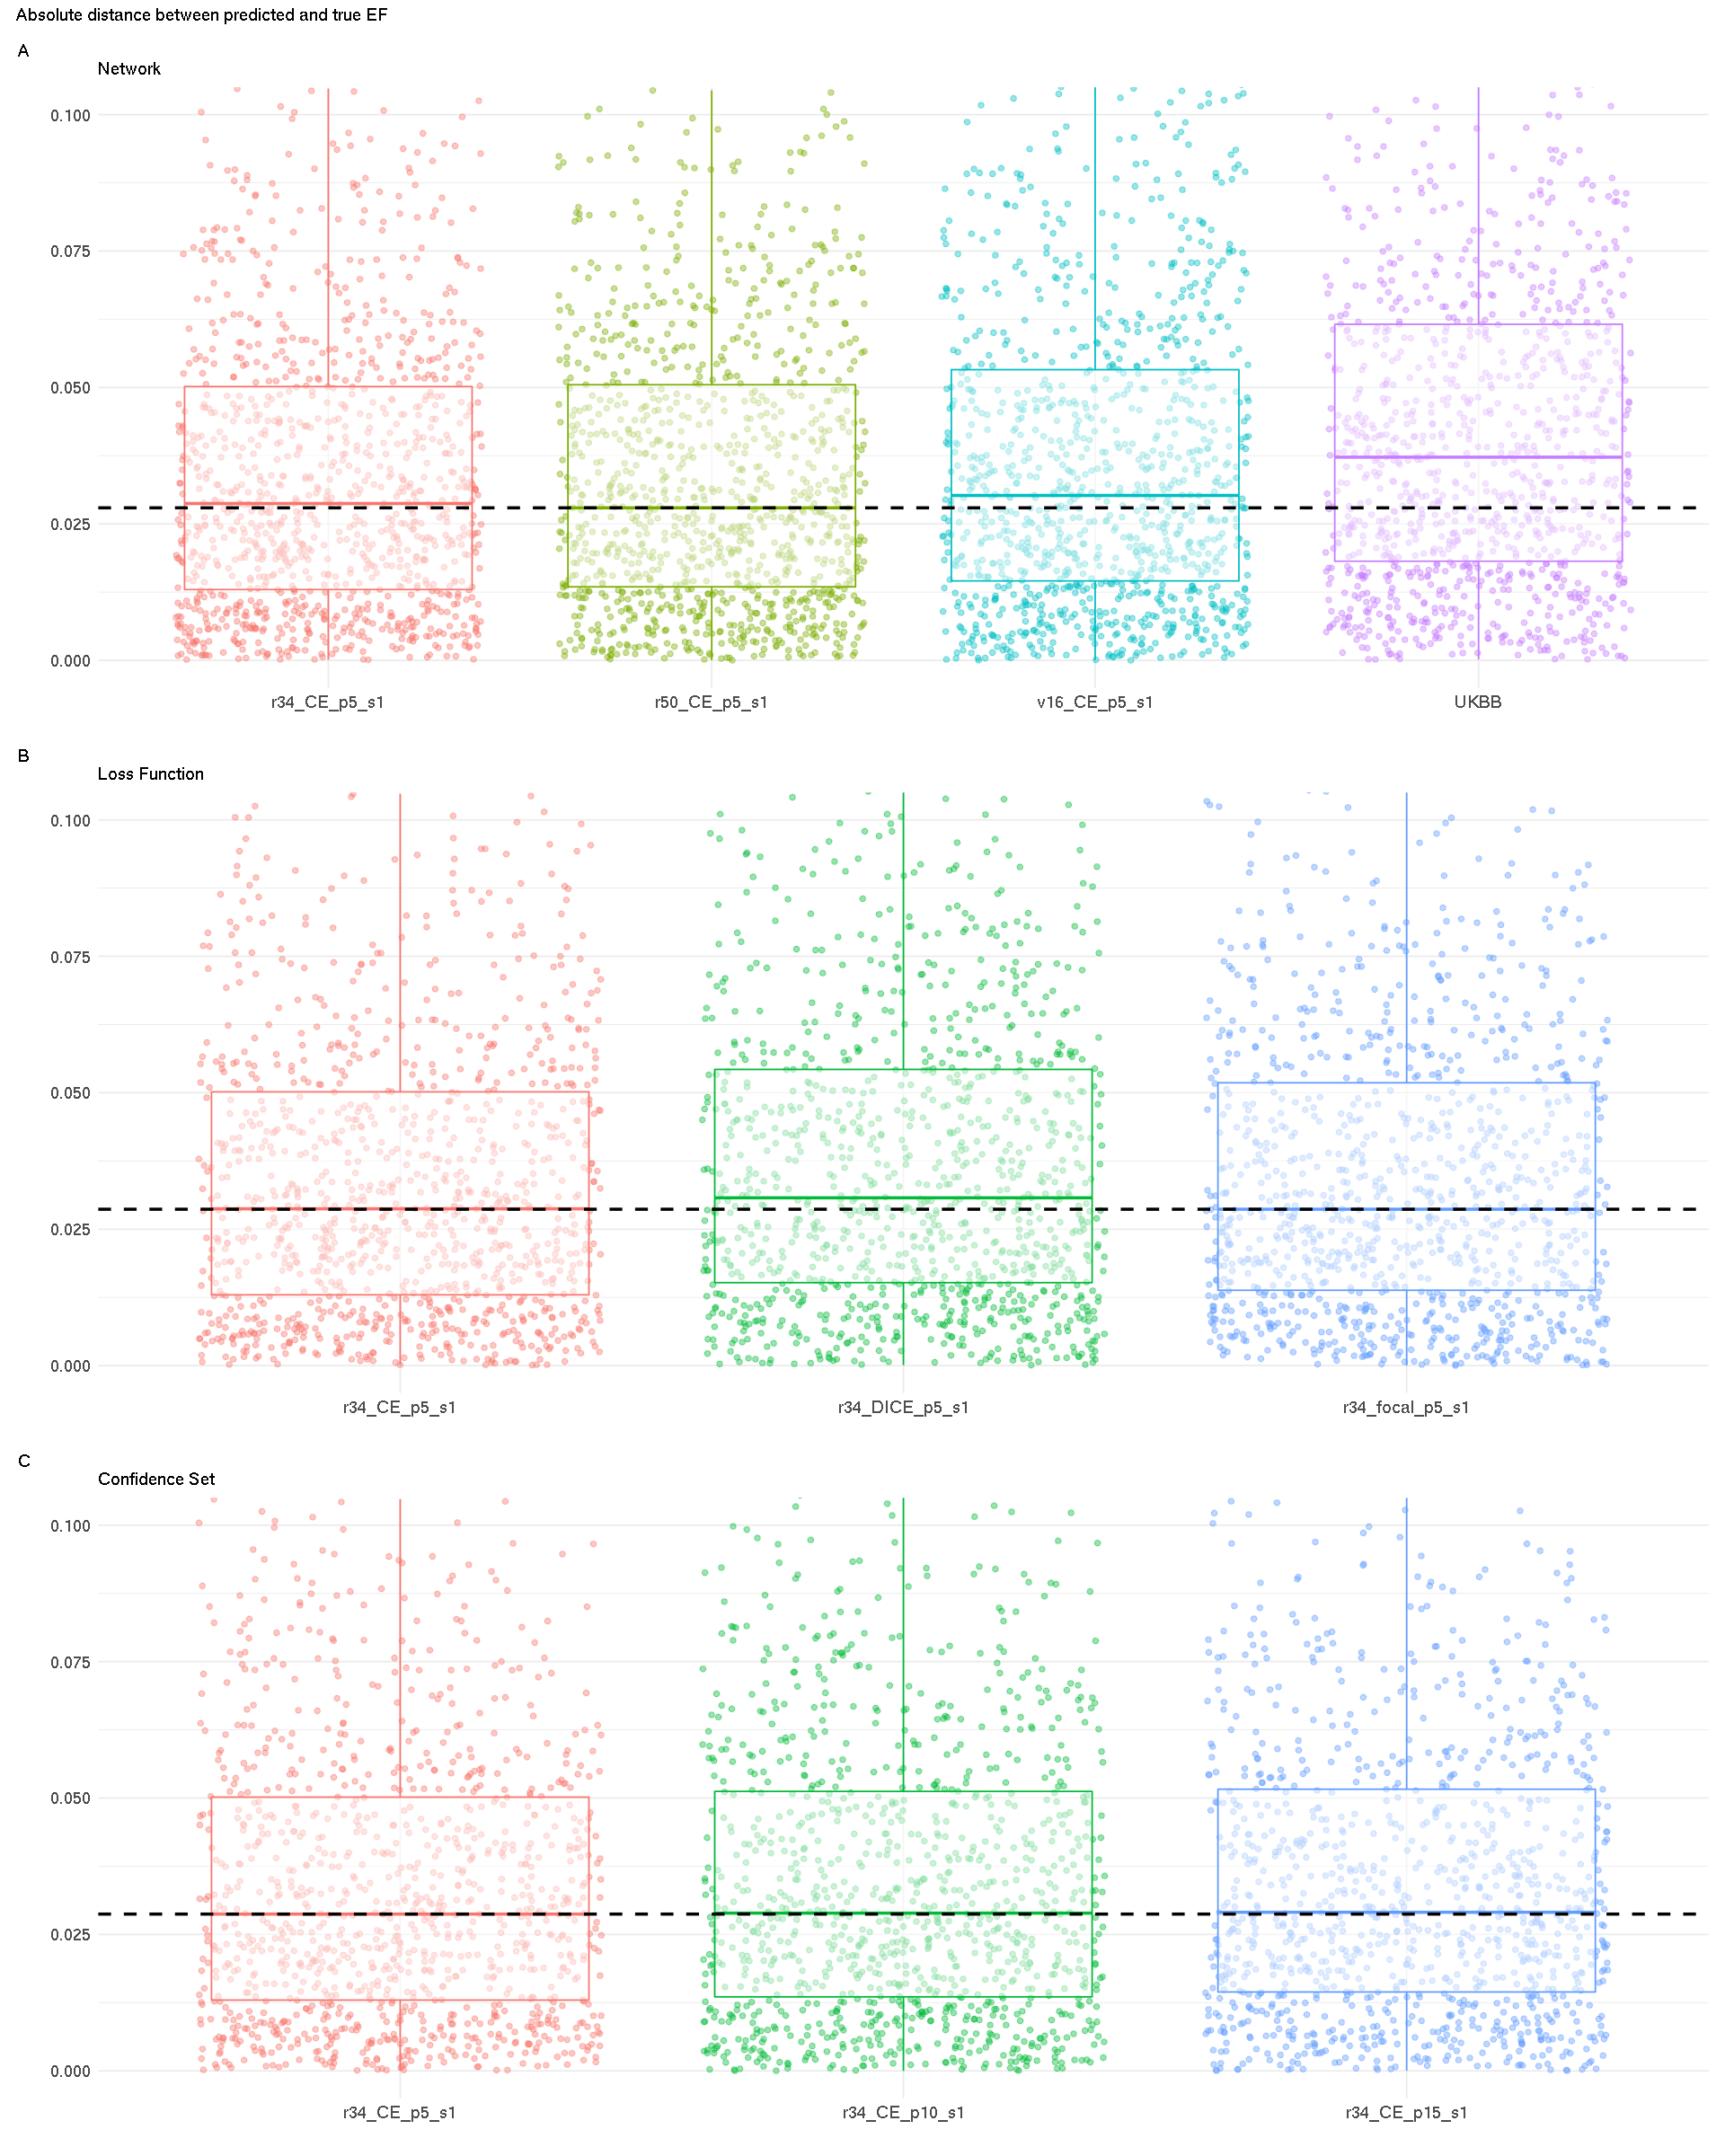

In [22]:
fig1_a <- ef %>%
    filter(str_detect(method, "p05_s256$") | method=="UKBB") %>%
    mutate(
        method = str_replace(method, "p05_s256", "CE_p5_s1"),
        method = fct_relevel(method, "UKBB", after = 3)
    ) %>%
    ggplot(aes(method, abs(distance), color=method)) +
    geom_jitter(alpha=.4) +
    geom_boxplot(alpha=.5,outlier.shape = NA) +
    geom_hline(yintercept=0.02794319,lty=2,lwd=1) +
    coord_cartesian(ylim=c(0,.1)) +
    ggtitle("Network") + xlab('') + ylab('') + theme_minimal() + theme(legend.position = "none",axis.text=element_text(size=12))

fig1_b <- ef %>%
    filter(str_detect(method, "r34_p05_s256"), !str_detect(method, "Tfms")) %>%
    mutate(
        method = str_replace(method, "_p05_s256", ""),
        method = str_replace(method, "^r34$", "r34_CE_p5_s1"),
        method = str_replace(method, "r34_dice", "r34_DICE_p5_s1"),
        method = str_replace(method, "r34_focal", "r34_focal_p5_s1"),
    ) %>%
    ggplot(aes(method, abs(distance), color=method)) +
    geom_jitter(alpha=.4) +
    geom_boxplot(alpha=.5,outlier.shape = NA) +
    geom_hline(yintercept=0.02864917,lty=2,lwd=1) +
    coord_cartesian(ylim=c(0,.1)) +
    # scale_y_log10() +
    ggtitle("Loss Function") + xlab('') + ylab('') + theme_minimal() + theme(legend.position = "none",axis.text=element_text(size=12))

fig1_c <- ef %>%
    filter(str_detect(method, "r34_p.._s256$")) %>%
    mutate(
        method = str_replace(method, "_p", "_CE_p"),
        method = str_replace(method, "s256", "s1"),
        method = str_replace(method, "p05", "p5"),
        method = fct_relevel(method, "r34_CE_p5_s1")
    ) %>%
    ggplot(aes(method, abs(distance), color=method)) +
    geom_jitter(alpha=.4) +
    geom_boxplot(alpha=.5,outlier.shape = NA) +
    geom_hline(yintercept=0.02873464,lty=2,lwd=1) +
    coord_cartesian(ylim=c(0,.1)) +
    ggtitle("Confidence Set") + xlab('') + ylab('') + theme_minimal() + theme(legend.position = "none",axis.text=element_text(size=12))


options(repr.plot.width=16, repr.plot.height=20)
fig1_a / fig1_b / fig1_c + plot_annotation(tag_levels = 'A', title="Absolute distance between predicted and true EF")
options(repr.plot.width=16, repr.plot.height=10)

## Performance on unrotated images

The term "unrotated images" refers to the original images in the kaggle dataset that had `Rows<Columns`. For better performance a rotated copy was used for labelling with `ukbb_cardiac`. The images in the original orientation (hence "unrotated") are used now to see how well the networks deal with these.

In [23]:
systole_unrot <- data_un_rot %>%
    select(Id, GroundTruth=Systole, UKBB=LVESV) %>%
    left_join(select(rn34_5percent_128, Id, r34_p05_s128=own_sys), by="Id") %>%
    left_join(select(rn50_5percent_256, Id, r50_p05_s256=own_sys), by="Id") %>%
    left_join(select(vgg16_5percent_256, Id, v16_p05_s256=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256, Id, r34_p05_s256=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256_focal, Id, r34_p05_s256_focal=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256_dice, Id, r34_p05_s256_dice=own_sys), by="Id") %>%
    left_join(select(rn34_10percent_256, Id, r34_p10_s256=own_sys), by="Id") %>%
    left_join(select(rn34_5percent_256_extremeTfms, Id, r34_p05_s256_extremeTfms=own_sys), by="Id") %>%
    left_join(select(rn34_15percent_256, Id, r34_p15_s256=own_sys), by="Id") %>%
    gather("method", "prediction", -1:-2) %>%
    mutate(distance=prediction-GroundTruth)

diastole_unrot <- data_un_rot %>%
    select(Id, GroundTruth=Diastole, UKBB=LVEDV) %>%
    left_join(select(rn34_5percent_128, Id, r34_p05_s128=own_dia), by="Id") %>%
    left_join(select(rn50_5percent_256, Id, r50_p05_s256=own_dia), by="Id") %>%
    left_join(select(vgg16_5percent_256, Id, v16_p05_s256=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256, Id, r34_p05_s256=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256_focal, Id, r34_p05_s256_focal=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256_dice, Id, r34_p05_s256_dice=own_dia), by="Id") %>%
    left_join(select(rn34_10percent_256, Id, r34_p10_s256=own_dia), by="Id") %>%
    left_join(select(rn34_5percent_256_extremeTfms, Id, r34_p05_s256_extremeTfms=own_dia), by="Id") %>%
    left_join(select(rn34_15percent_256, Id, r34_p15_s256=own_dia), by="Id") %>%
    gather("method", "prediction", -1:-2) %>%
    mutate(distance=prediction-GroundTruth)


In [24]:
ef_unrot <- systole_unrot %>%
    left_join(diastole_unrot, by=c("Id","method")) %>%
    mutate(
        true_ef=(GroundTruth.y-GroundTruth.x)/GroundTruth.y,
        pred_ef=(prediction.y-prediction.x)/prediction.y, 
        distance=true_ef-pred_ef
    ) %>%
    replace_na(list(distance=1))

In [25]:
round_to = 4
ef_unrot %>% group_by(method) %>%
    mutate(distance=abs(distance)) %>%
    summarize(mean=mean(distance),sd=sd(distance),median=median(distance),iqr=IQR(distance),mad=mad(distance)) %>%
    arrange(mean) %>%
    mutate_if(is.numeric, round, 4) %>%
    mutate_if(is.numeric, `*`, 100)

method                   mean  sd    median iqr   mad  
1  r34_p05_s256_extremeTfms  4.08  3.92  3.06   4.18  2.90
2  v16_p05_s256              6.86  6.19  5.26   6.73  4.75
3  r34_p05_s256_dice         8.47  8.86  5.10   9.34  5.54
4  r50_p05_s256              8.73  9.57  5.77   8.60  5.95
5  r34_p05_s256             10.17 11.08  6.08  10.35  6.09
6  r34_p10_s256             10.54 10.80  6.50  11.08  6.81
7  r34_p15_s256             11.44 11.69  7.33  13.25  7.95
8  UKBB                     14.67 12.69 11.05  16.21 11.49
9  r34_p05_s256_focal       15.02 14.08 10.85  17.89 11.76
10 r34_p05_s128             16.43 12.67 14.28  18.65 13.38

The network with "extremeTfms" clearly performs best.

Warning message:
“Removed 10 rows containing missing values (geom_point).”

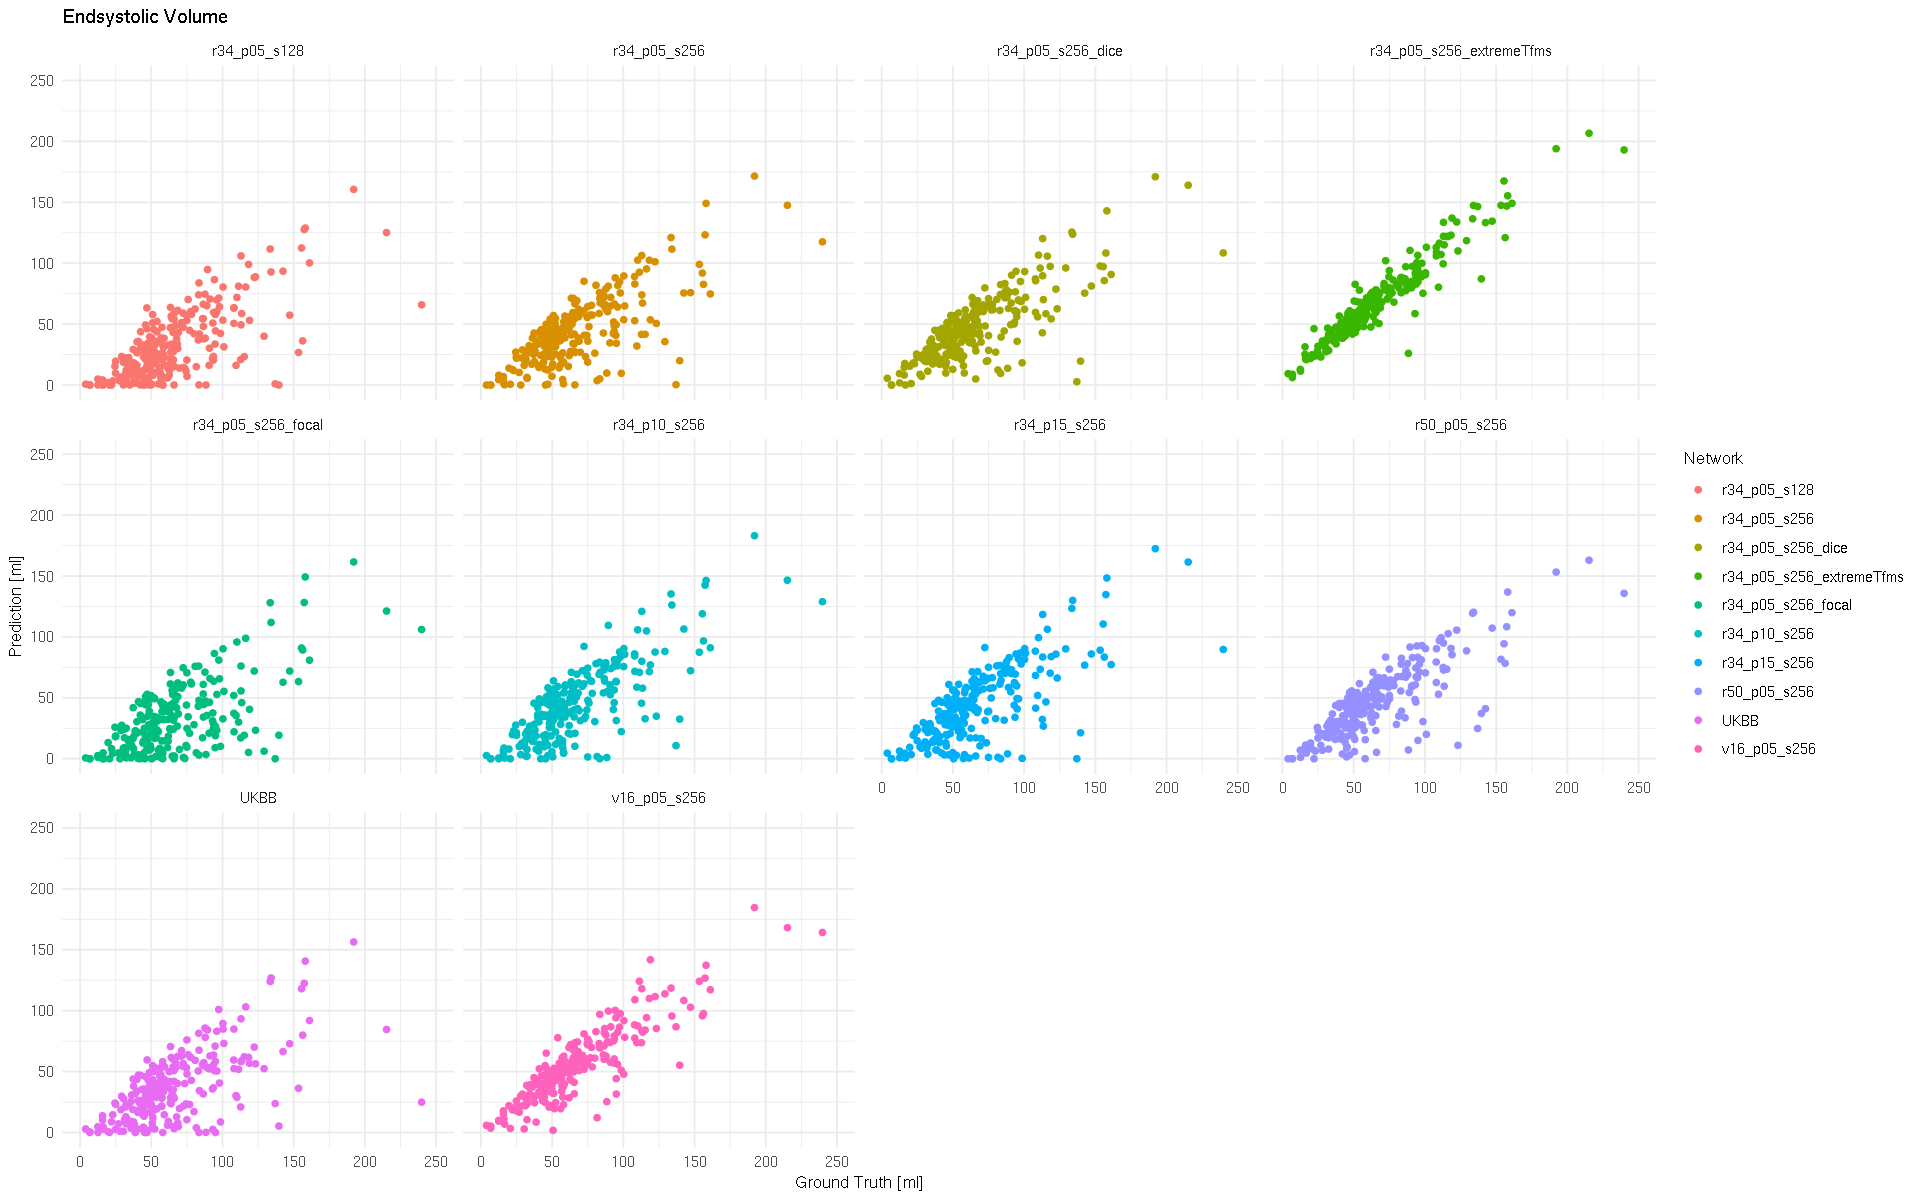

In [26]:
systole_unrot %>%
    mutate(Network = method) %>%
    ggplot(aes(GroundTruth, prediction, color=Network)) +
    geom_point() +
    ylim(c(0,250)) +
    xlim(c(0,250)) +
    facet_wrap(.~method) +
    ggtitle("Endsystolic Volume") +
    xlab("Ground Truth [ml]") +
    ylab("Prediction [ml]") +
    theme_minimal()

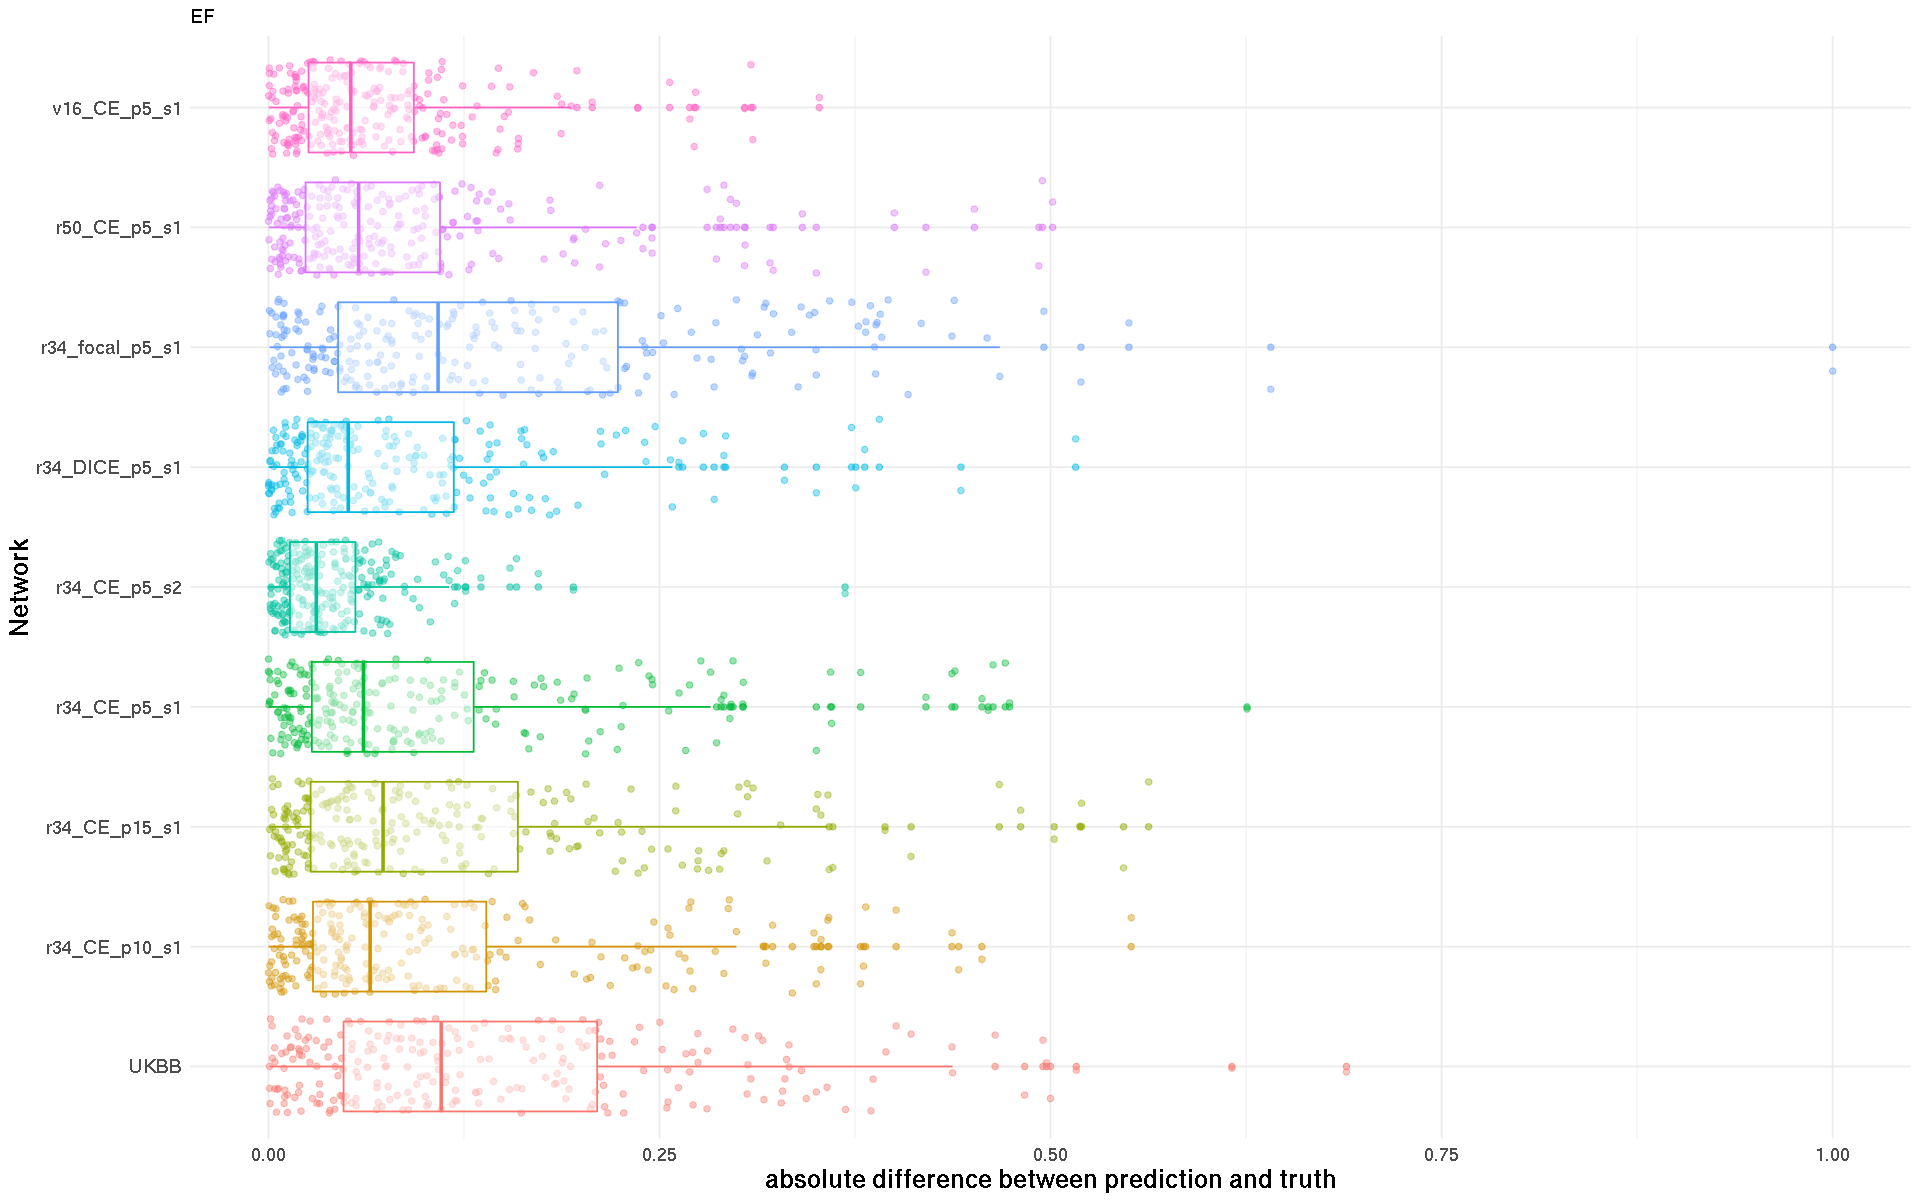

In [27]:
ef_unrot %>%
    filter(!str_detect(method,"s128")) %>%
    mutate(
        method = str_replace(method, "_p", "_CE_p"),
        method = str_replace(method, ".*focal", "r34_focal_p5_s1"),
        method = str_replace(method, ".*dice", "r34_DICE_p5_s1"),
        method = str_replace(method, "_s256", "_s1"),
        method = str_replace(method, "_s1_extremeTfms", "_s2"),
        method = str_replace(method, "_p05_", "_p5_"),
        method = fct_relevel(method, "UKBB")
    ) %>%
    ggplot(aes(method, abs(distance), color=method)) +
    geom_jitter(alpha=.4) +
    geom_boxplot(alpha=.5) +
    ggtitle("EF") + xlab('Network') + ylab('absolute difference between prediction and truth') + theme_minimal() +
    theme(legend.position = "none", axis.text=element_text(size=12), axis.title=element_text(size=14,face="bold")) +
    coord_flip()

## PCA

Explore if there is an effect of architecture, size, etc. on the predictions in the first couple of principal components

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

Importance of components:
                            PC1      PC2      PC3     PC4      PC5      PC6
Standard deviation     170.9731 107.1026 50.99142 42.6294 37.12602 29.87049
Proportion of Variance   0.6016   0.2361  0.05351  0.0374  0.02837  0.01836
Cumulative Proportion    0.6016   0.8377  0.89119  0.9286  0.95696  0.97532
                            PC7      PC8      PC9     PC10      PC11
Standard deviation     23.10910 18.99270 13.71480 10.78613 1.353e-13
Proportion of Variance  0.01099  0.00742  0.00387  0.00239 0.000e+00
Cumulative Proportion   0.98631  0.99373  0.99761  1.00000 1.000e+00

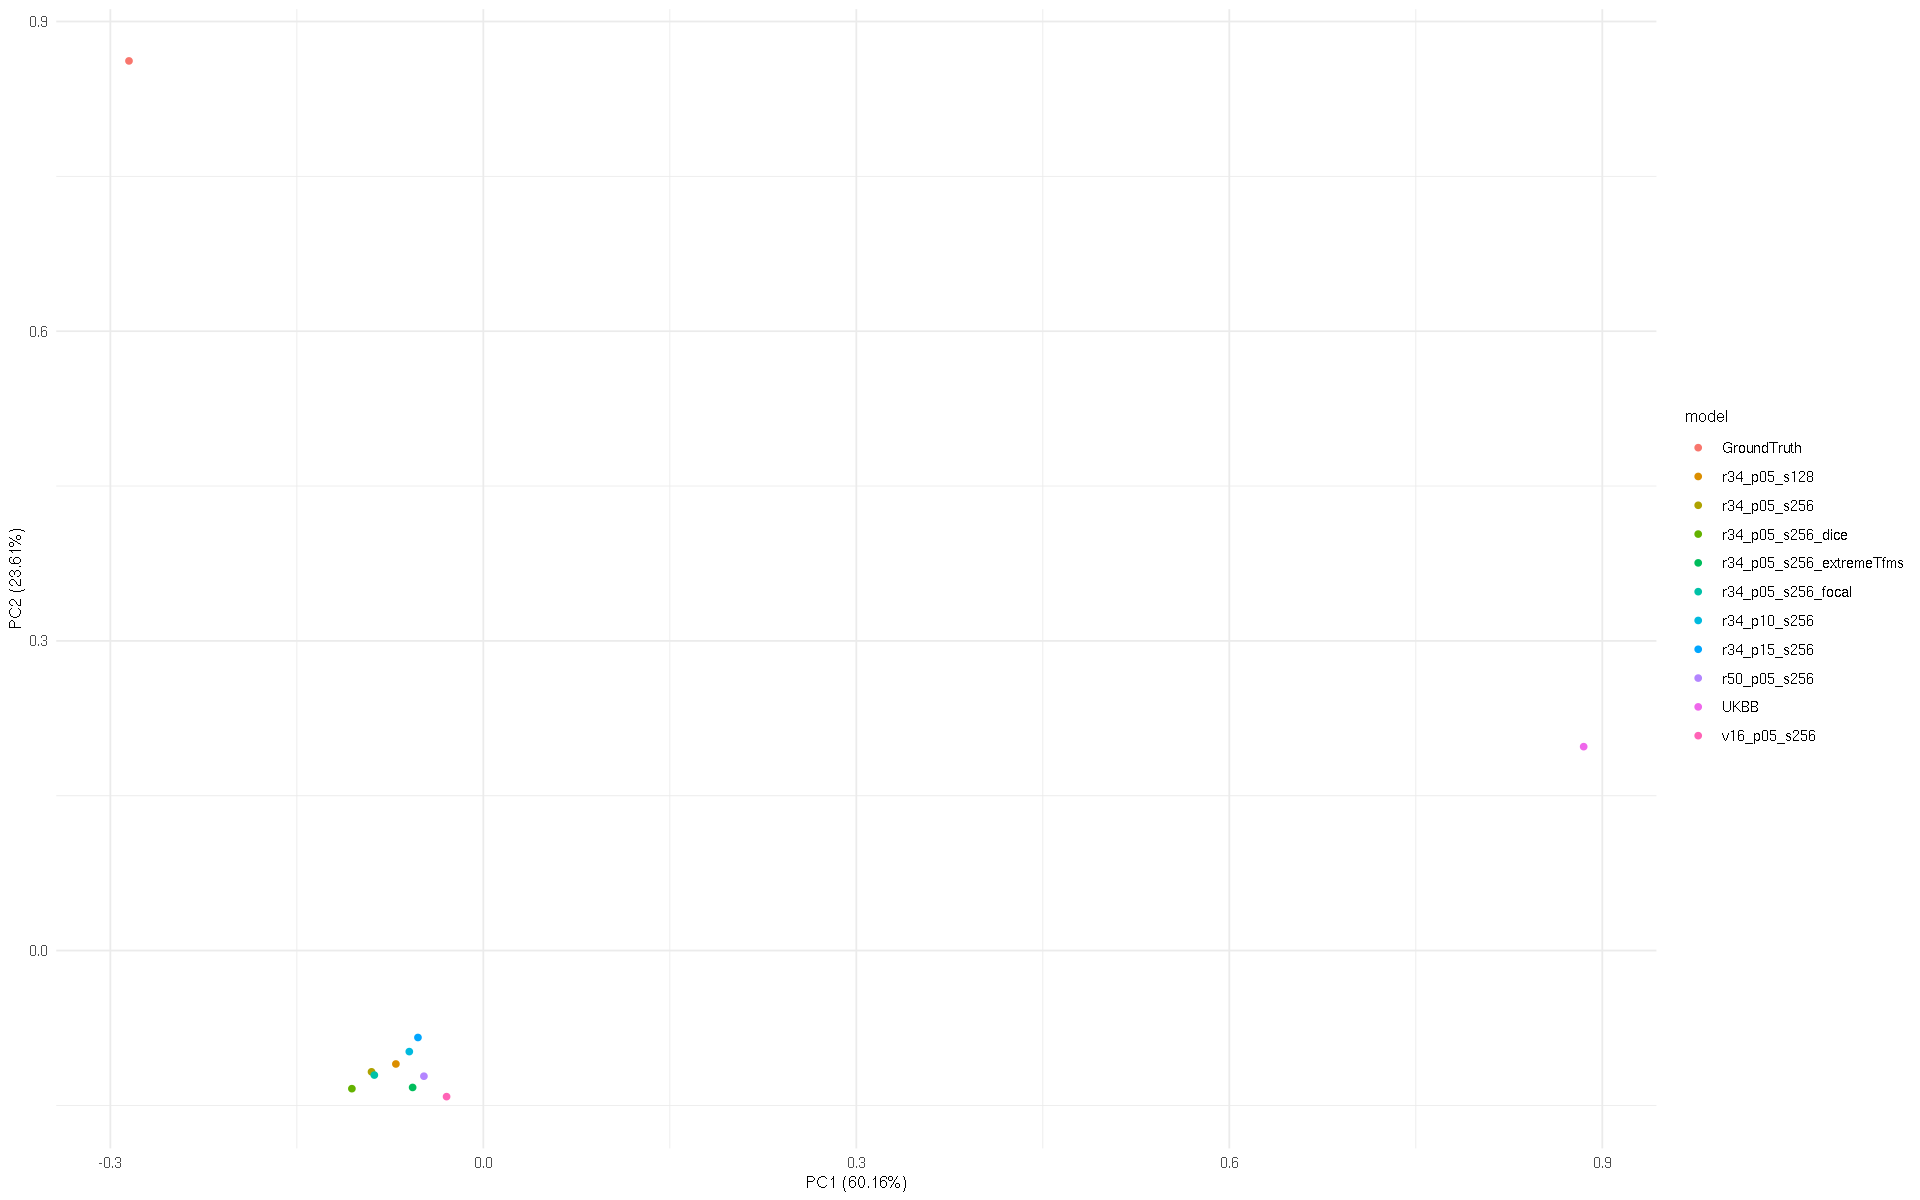

In [28]:
sys_wide <- systole %>% select(-distance) %>% spread(method, prediction) %>% select(-Id) %>% t
pca_systole <- sys_wide %>% prcomp
sys_wide <- sys_wide %>% as_tibble(rownames = "model")
summary(pca_systole)
autoplot(pca_systole, data=sys_wide, colour="model")

&rArr; The first two principal components are dominated by the difference between our predictions to UKBB and to the ground truth. So eliminate these and see what remains.

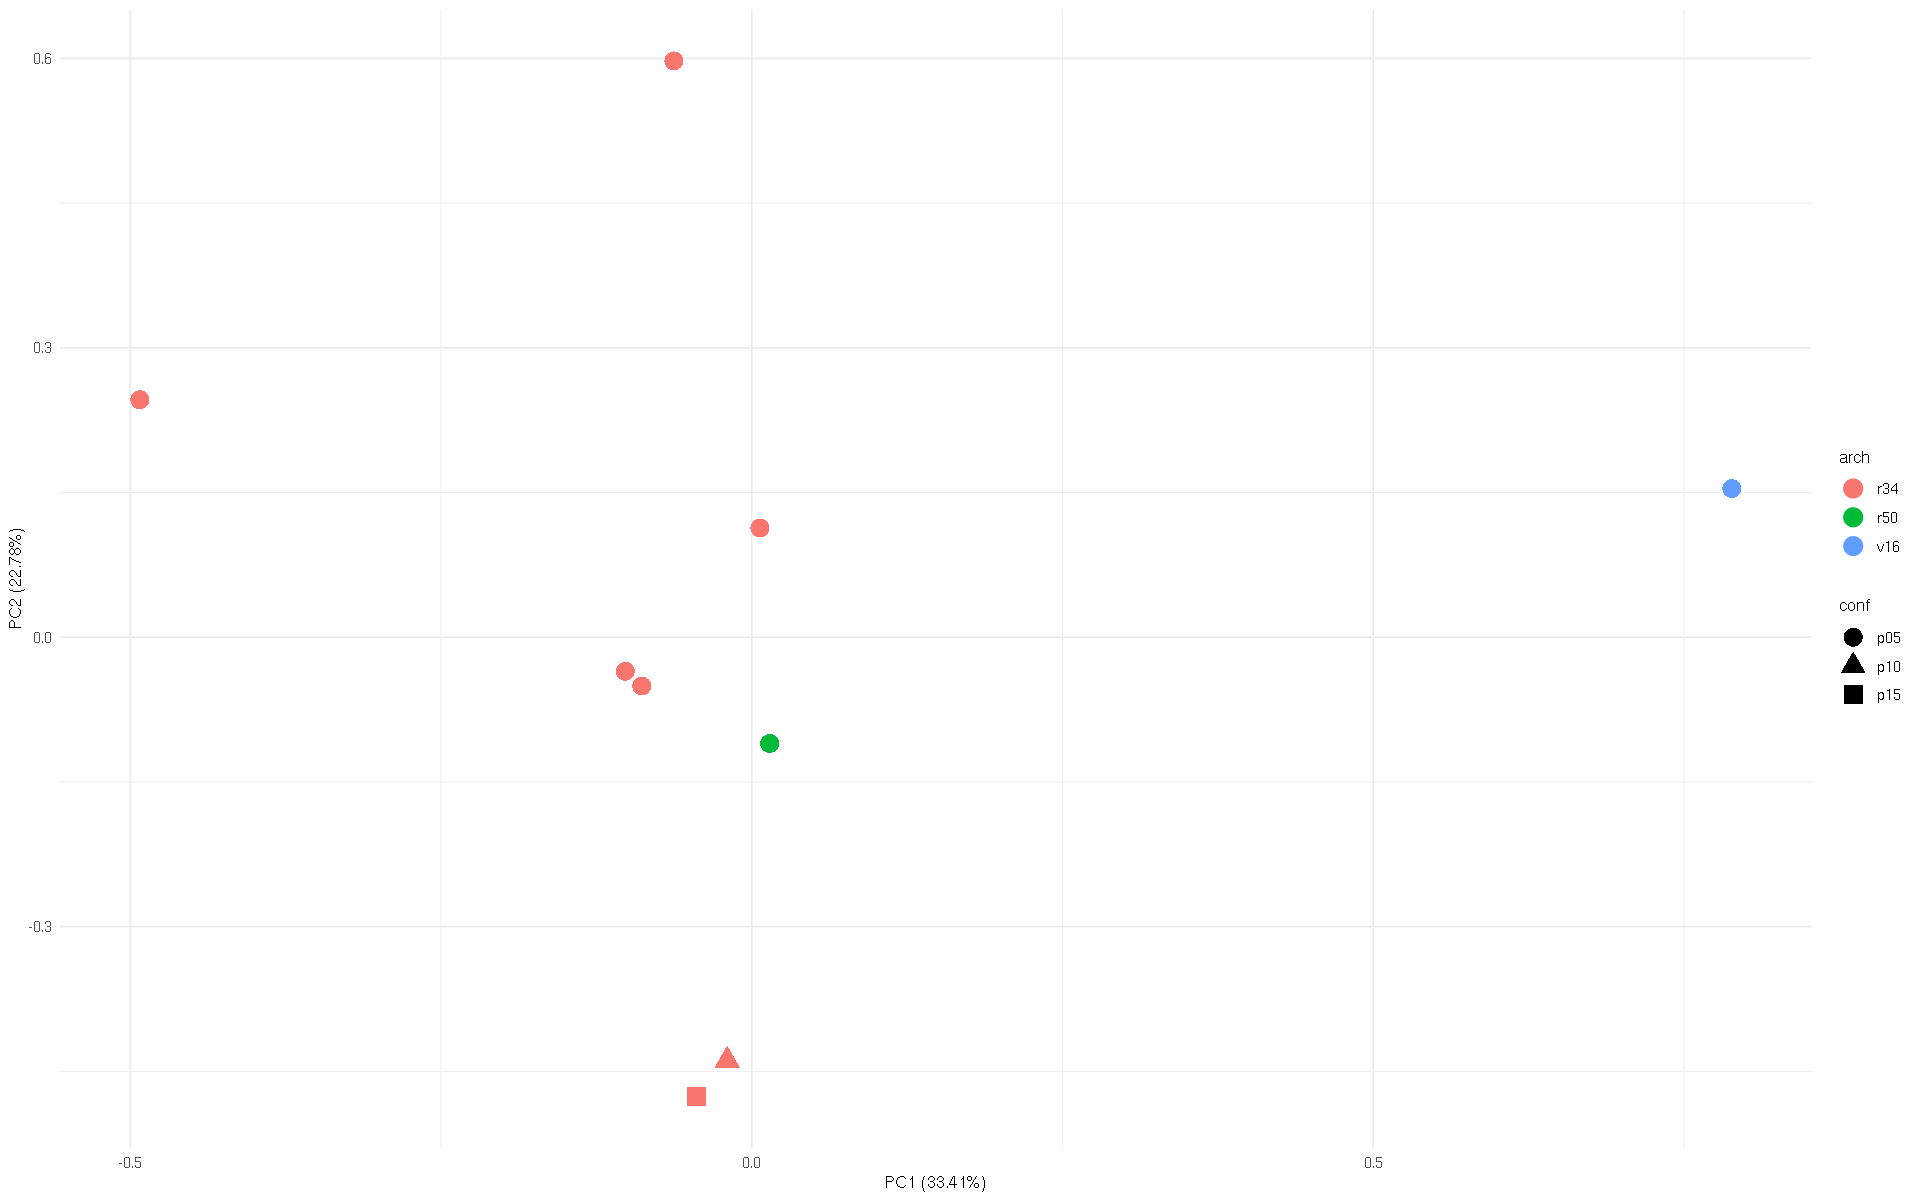

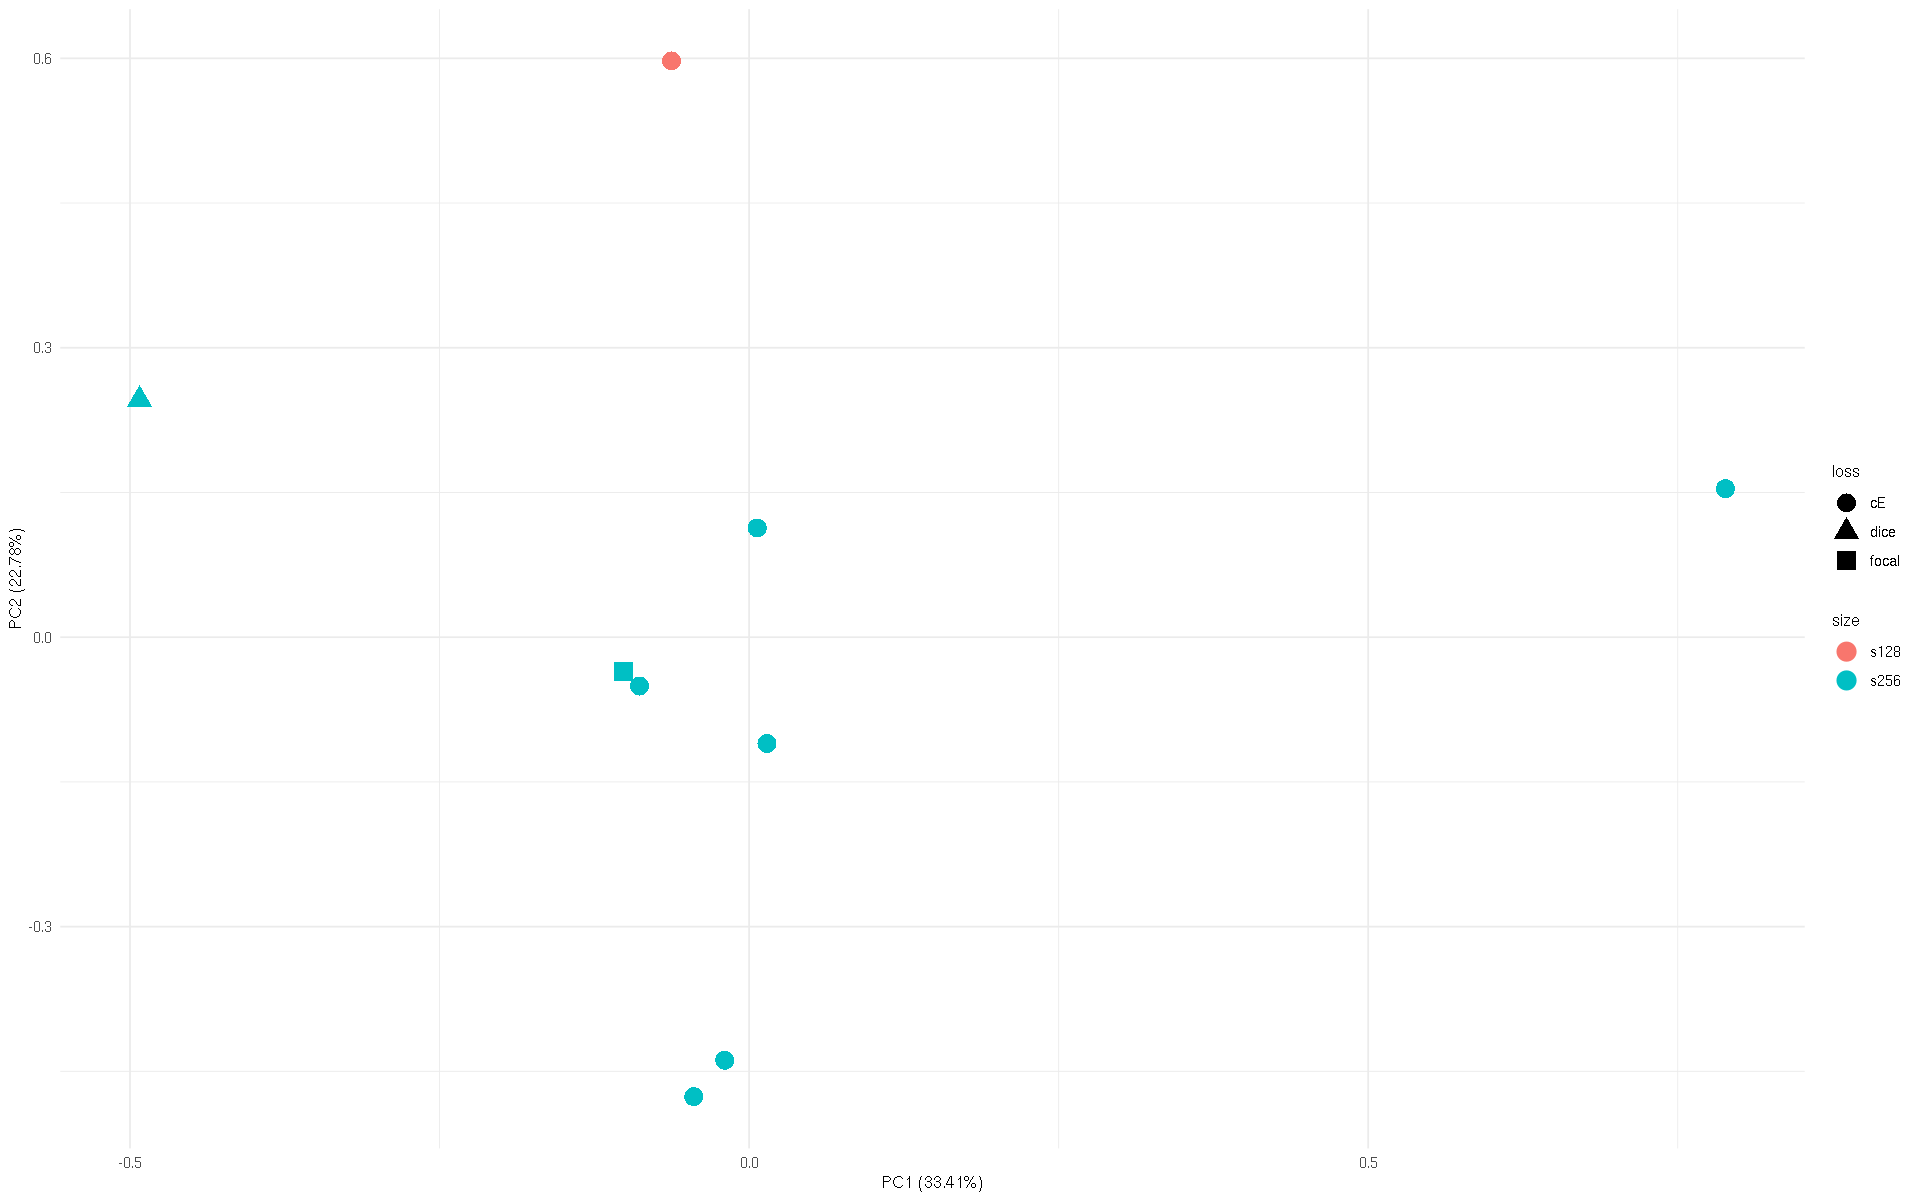

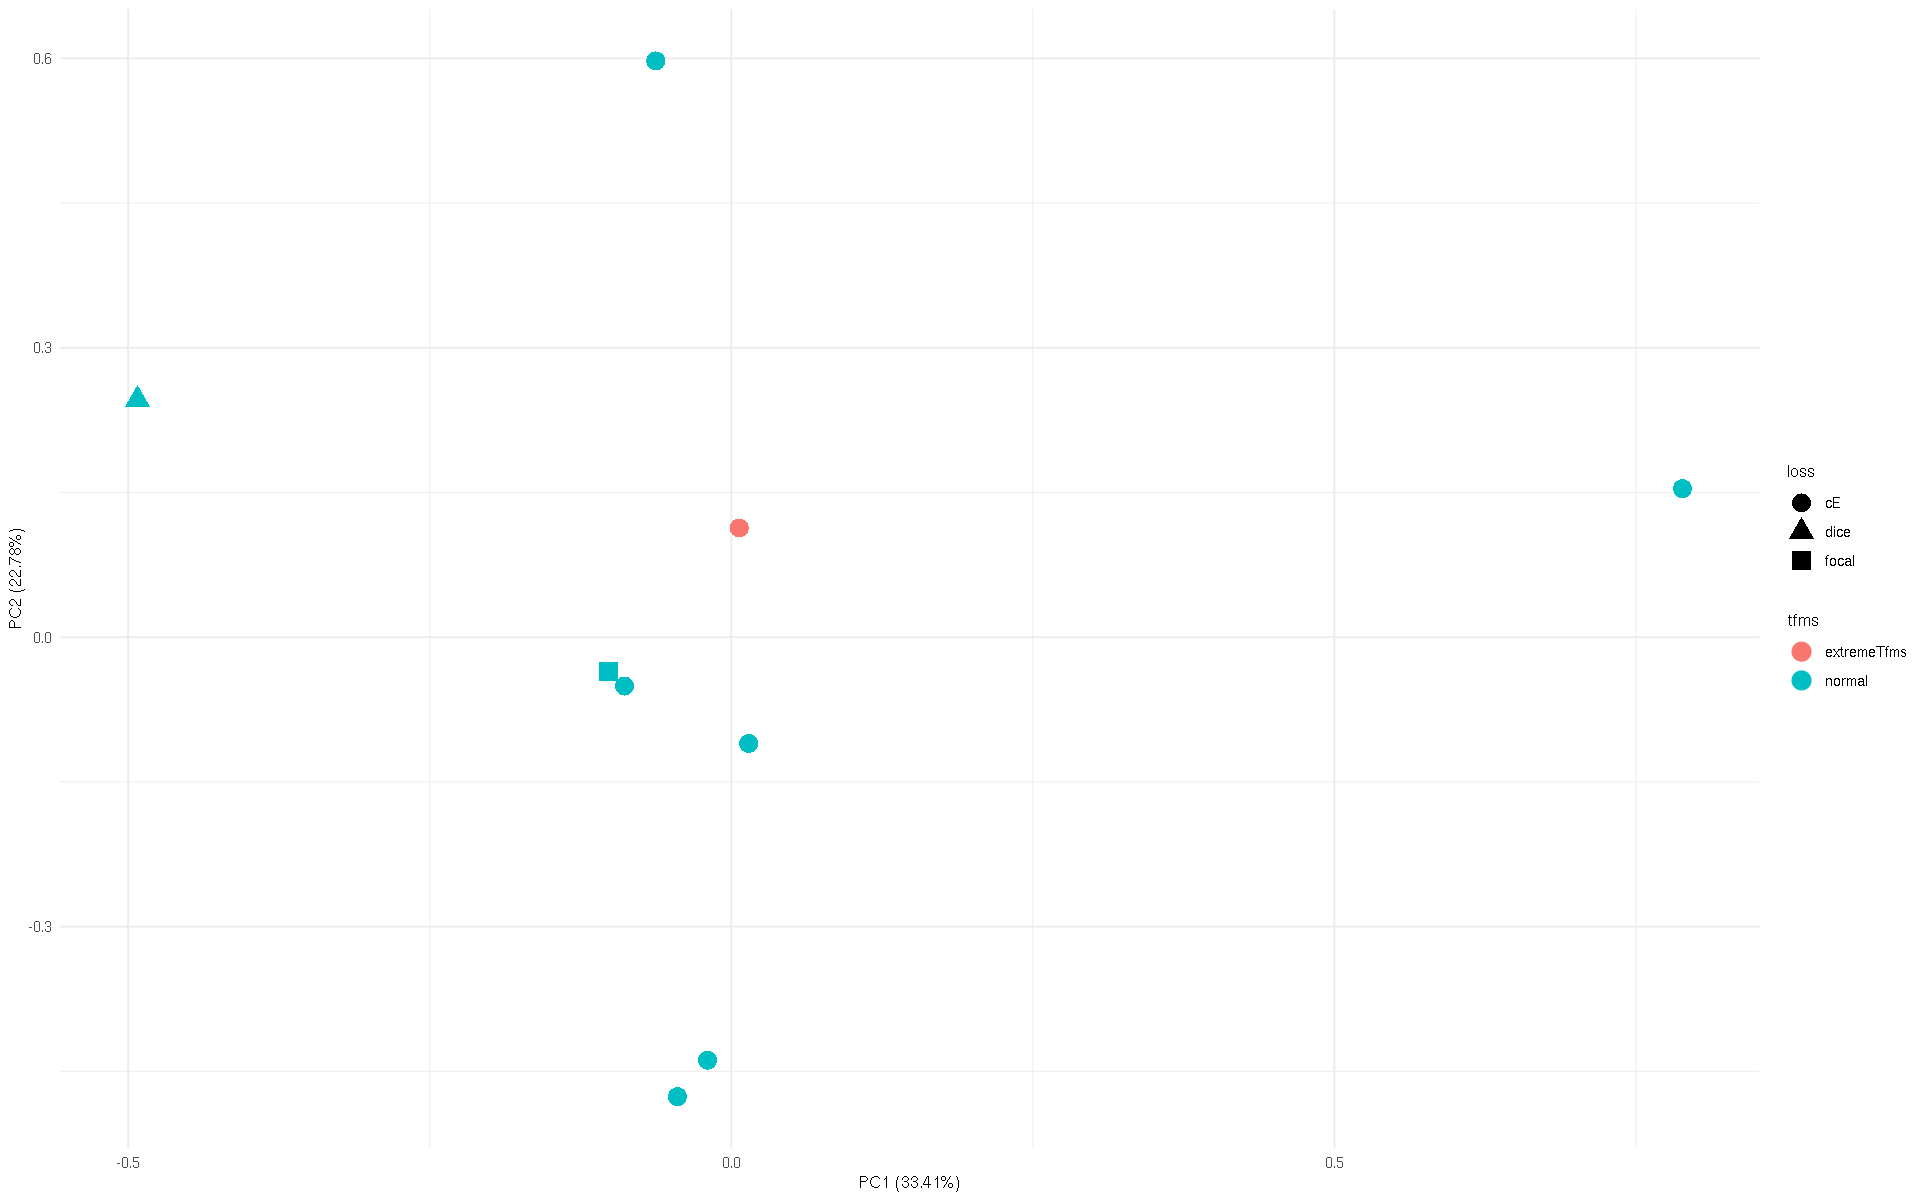

In [29]:
# without GroundTruth and UKBB
sys_wide <- systole %>% select(-distance,-GroundTruth) %>% filter(method != 'UKBB') %>% spread(method, prediction) %>% select(-Id) %>% t
pca_systole <- sys_wide %>% prcomp
sys_wide <- sys_wide %>%
    as_tibble(rownames = "model") %>%
    separate(model, c("arch","conf","size","loss"), sep="_", fill="right") %>% 
    mutate(tfms=if_else(str_detect(loss,"Tfms"),loss,"normal"),loss=if_else(loss %in% c("dice","focal"),loss,"cE")) %>%
    replace_na(list(tfms="normal"))
autoplot(pca_systole, data=sys_wide, colour="arch", shape="conf", size=5)
autoplot(pca_systole, data=sys_wide, colour="size", shape="loss", size=5)
autoplot(pca_systole, data=sys_wide, colour="tfms", shape="loss", size=5)

There are not enough data points for proper analysis. But it seems the three most extreme outliers are vgg16, dice loss and size 128.